<a href="https://colab.research.google.com/github/fdavenport/CIVE480A6-climate-change-impacts/blob/main/lectures/06_Analyzing_Extreme_Events.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIVE 480A6: Climate Change Risks and Impacts
## Week 9: Analyzing Extreme Events

This week's Objectives:
1. Analyze the distribution of daily maximum temperature.
2. Calculate percentiles of the temperature distribution.
3. Calculate how often daily temperatures exceed certain thresholds.
4. Calculate "block maxima" (in this case, the hottest day of the year).
5. Learn how to fit a Generalized Extreme Value (GEV) distribution to the time series of block maxima.

## Part 1: Daily Temperature Data

Today we will be looking at daily temperature data. We will again be using data from the [Global Historical climatology Network (GHCN-D)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily).  

We will be looking specifically at data from a weather station near Atlanta, Georgia. The data file contains the high and low (maximum and minimum) temperatures for each day.

<img src="https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/main/lectures/img/atlanta_map.png" width="400">
<img src="https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/main/lectures/img/heatwave.jpg" width="300">

In [1]:
# The data has already been added to the course github page at the following link:

atl_temp_data_url = "https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/refs/heads/main/lectures/data/USW00013874_atlanta_temp.csv"


In [2]:
# we are working with tabular data in a .csv file, so we need to import the pandas library

import pandas as pd

In [3]:
# read in the data

atl_data = pd.read_csv(atl_temp_data_url)

In [4]:
# look at the data

atl_data

,DATE,TMAX_degC,TMIN_degC
0,1940-01-01,1.7,-7.2
1,1940-01-02,-0.6,-9.4
2,1940-01-03,2.8,-8.9
3,1940-01-04,5.6,-5.6
4,1940-01-05,3.9,-3.3
...,...,...,...
30310,2022-12-27,11.1,-1.0
30311,2022-12-28,14.4,-1.0
30312,2022-12-29,18.9,5.6
30313,2022-12-30,19.4,8.3


We see that the table contains daily data beginning in 1940 and ended in 2022. There are two variable columns that correspond to the high (max) and low (min) temperature on each day.

In [5]:
# convert DATE column to datetime format so that we can add year and month information

atl_data["DATE"] = pd.to_datetime(atl_data["DATE"])
atl_data["year"] = atl_data["DATE"].dt.year
atl_data["month"] = atl_data["DATE"].dt.month

atl_data.set_index("DATE", inplace=True)

atl_data


,TMAX_degC,TMIN_degC,year,month
DATE,,,,
1940-01-01,1.7,-7.2,1940,1
1940-01-02,-0.6,-9.4,1940,1
1940-01-03,2.8,-8.9,1940,1
1940-01-04,5.6,-5.6,1940,1
1940-01-05,3.9,-3.3,1940,1
...,...,...,...,...
2022-12-27,11.1,-1.0,2022,12
2022-12-28,14.4,-1.0,2022,12
2022-12-29,18.9,5.6,2022,12


In [6]:
# get a summary of the data


atl_data.describe()

,TMAX_degC,TMIN_degC,year,month
count,30315.000000,30315.000000,30315.000000,30315.000000
mean,22.272053,11.470912,1981.000627,6.522778
std,8.537343,8.480547,23.958183,3.448769
min,-9.400000,-22.200000,1940.000000,1.000000
25%,16.100000,4.400000,1960.000000,4.000000
50%,23.300000,12.200000,1981.000000,7.000000
75%,29.400000,19.400000,2002.000000,10.000000
max,41.100000,27.800000,2022.000000,12.000000


In [8]:
# import matplotlib.pyplot to make graphs


import matplotlib.pyplot as plt


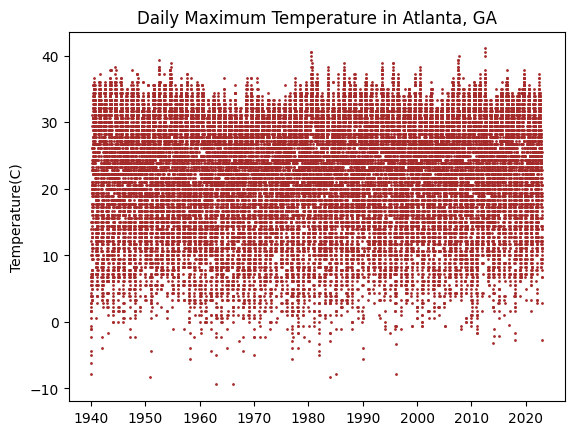

In [9]:
# make a plot of the data


fig, ax = plt.subplots()

ax.scatter(x = atl_data.index, y = atl_data["TMAX_degC"], s = 1, color = "brown")
ax.set_title("Daily Maximum Temperature in Atlanta, GA")
ax.set_ylabel("Temperature(C)");



We see that there is a large spread in daily maximum temperature in Atlanta, with daily high temperatures ranging anywhere from -10C on the coldest days to 40C on the very hottest days.

It's hard to tell whether there are trends in the data, but it does appear that there haven't been as many extremely cold days since ~2000.

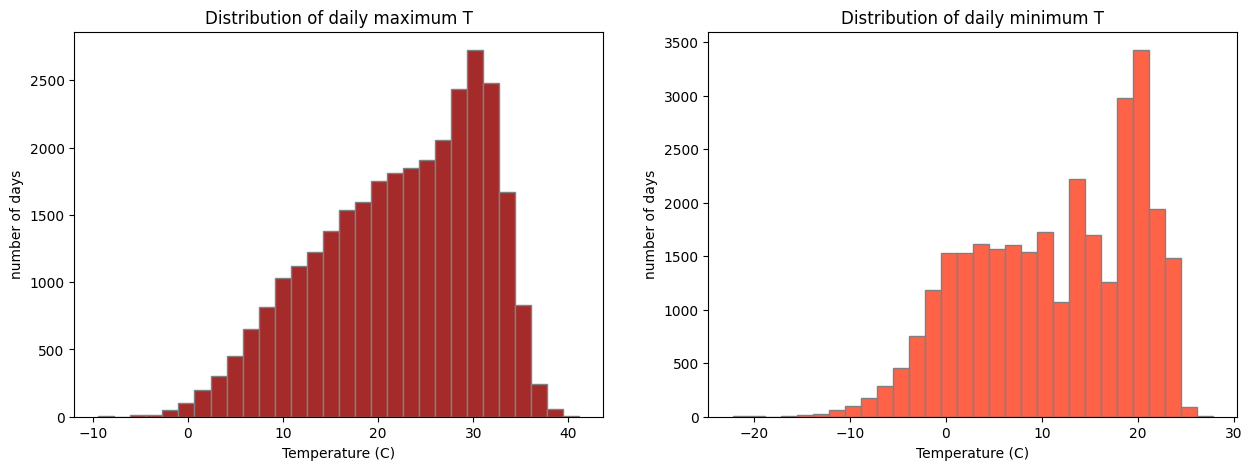

In [10]:
# create a histogram of the daily temperature data


fig, axes = plt.subplots(1, 2, figsize = (15, 5))


axes[0].hist(x = atl_data["TMAX_degC"], bins = 30, color = "brown", edgecolor = "gray");
axes[0].set_title("Distribution of daily maximum T")
axes[0].set_xlabel("Temperature (C)")
axes[0].set_ylabel("number of days");

axes[1].hist(x = atl_data["TMIN_degC"], bins = 30, color = "tomato", edgecolor = "gray");
axes[1].set_title("Distribution of daily minimum T")
axes[1].set_xlabel("Temperature (C)")
axes[1].set_ylabel("number of days");

## Part 2: Calculating percentiles and exceedences

In this section, we are going to look at the 95th percentile minimum and maximum temperature within the summer months (June, July, and August) in Atlanta, GA. This will give us a sense for what a rare or "extreme" hot temperature would look like at this particular location.

Oftentimes, we use percentiles to define extremes, because what is extreme in one place might not be extreme in another location. For example, 100 F is very extreme in Alaska, but not so extreme in Phoenix, AZ.

First let's look at daily maximum summer temperatures in Atlanta:

In [11]:
## subset the data for summer months

summer_data = atl_data.loc[atl_data["month"].isin([6, 7, 8])]

summer_data


,TMAX_degC,TMIN_degC,year,month
DATE,,,,
1940-06-01,27.8,15.6,1940,6
1940-06-02,28.9,15.6,1940,6
1940-06-03,30.6,15.0,1940,6
1940-06-04,30.6,17.2,1940,6
1940-06-05,32.2,18.9,1940,6
...,...,...,...,...
2022-08-27,32.2,22.8,2022,8
2022-08-28,31.7,22.8,2022,8
2022-08-29,32.2,22.8,2022,8


We will use the [quantile()](https://numpy.org/doc/2.0/reference/generated/numpy.quantile.html) function from the numpy package to calculate the 95th percentile

In [12]:
# import numpy

import numpy as np


In [13]:
# for the np.quantile function,
# the first argument is our data, the second argument is the quantile (aka percentile) that we want to calculate

# calculate the 95th percentile of TMAX for all summer days:

TMAX_p95 = np.quantile(summer_data["TMAX_degC"], q = 0.95)

TMAX_p95

35.6

In [14]:
## conver to Fahrenheit

TMAX_p95*9/5+32

96.08000000000001

This tells us that about 5% of summer days in Atlanta have temperatures above 96.08 F.

How many days have maximum temperatures above the 95th percentile? To answer this, we will compare the temperature on each day to our 95th percentile threshold to see if the value is greater than or equal to the threshold. We will first do this for the first 10 values from our table to see how this works:  

In [15]:
# print out the first 10 rows of our table

summer_data.iloc[0:10]

,TMAX_degC,TMIN_degC,year,month
DATE,,,,
1940-06-01,27.8,15.6,1940,6
1940-06-02,28.9,15.6,1940,6
1940-06-03,30.6,15.0,1940,6
1940-06-04,30.6,17.2,1940,6
1940-06-05,32.2,18.9,1940,6
1940-06-06,35.6,19.4,1940,6
1940-06-07,35.6,20.6,1940,6
1940-06-08,33.3,20.6,1940,6
1940-06-09,30.0,18.3,1940,6


In [16]:
## compare these 10 values for
summer_data.iloc[1:10]["TMAX_degC"] >= TMAX_p95

,TMAX_degC
DATE,
1940-06-02,False
1940-06-03,False
1940-06-04,False
1940-06-05,False
1940-06-06,True
1940-06-07,True
1940-06-08,False
1940-06-09,False
1940-06-10,False


Python returns "False" if the temperature is lower than TMAX_p95, and "True" if the temperature is greater than TMAX_p95.

Conveniently, Python equates "True" with a value of 1, and "False" with a value of 0. If we take the sum of the True and False data, the total sum will be equal to the number of True cases.

In [17]:
sum(summer_data.iloc[1:10]["TMAX_degC"] >= TMAX_p95)

2

This tells us that there were two True cases within the first 10 rows. If we repeat this for all of the summer data, we will know the total number of days with temperatures greater than or equal to TMAX_p95:

In [18]:
sum(summer_data["TMAX_degC"] >= TMAX_p95)


456

There are 456 days with temperatures >= 35.6 C.

In [19]:
## get the total number of rows (aka days) in our data

len(summer_data)

7636

In [20]:
## calculate percentage of days with T > TMAX_p95

456/7636*100

5.971712938711367

5.97% of days have temperatures above TMAX_p95. This isn't exactly 5% because it turns out there are a lot of duplicate values in the data. Quite a few days have temperatures of exactly 35.6 C.

We can use the same function to calculate different percentiles:

In [21]:
# the 99th percentile of maximum daily temperature
np.quantile(summer_data["TMAX_degC"], q = 0.99)

37.2

In [22]:
# convert to Fahrenheit

37.2*9/5+32

98.96000000000001

In [23]:
# the 1st percentile of minimum daily summer temperature
# in other words, only 1% of summer days have temperatures below this value

np.quantile(summer_data["TMIN_degC"], q = 0.01)

13.9

In [24]:
# convert to F

13.9*9/5+32

57.02

## Part 3: Calculating changes in the frequency of extreme cold and extreme hot days

Let's calculate the frequency of extreme hot days over time to see if it has changed. We will look at summertime TMAX and TMIN.

While TMAX tells us the hottest conditions of the day, daily minimum temperatures (TMIN) are an especially important metric to understand the human health consequences of heat waves. If it stays very warm at night, people are unable to cool down, and sustained hot temperatures become more likely to cause negative health impacts.

In [25]:
TMIN_p95 = np.quantile(summer_data["TMIN_degC"], q=0.95)


In [26]:
## how many days are there with maximum temperatures above the 95th percentile in each year?
## Hint: let's use our code from previous lectures to loop through all of the years

annual_freq = pd.DataFrame(columns = ["year", "days_above_TMAX_p95", "days_above_TMIN_p95"], index = range(83))

for i, yr in enumerate(range(1940, 2023)):
  data_yr = summer_data[str(yr):str(yr)] # create a subset with summer data for the current year

  annual_freq.loc[i, "year"] = yr

  # check how many days exceeded the 95th percentile
  annual_freq.loc[i, "days_above_TMAX_p95"] = sum(data_yr["TMAX_degC"] >= TMAX_p95)
  annual_freq.loc[i, "days_above_TMIN_p95"] = sum(data_yr["TMIN_degC"] >= TMIN_p95)


In [27]:
## check the results

annual_freq

,year,days_above_TMAX_p95,days_above_TMIN_p95
0,1940,7,3
1,1941,3,3
2,1942,5,2
3,1943,17,5
4,1944,11,6
...,...,...,...
78,2018,0,9
79,2019,6,20
80,2020,1,12
81,2021,0,8


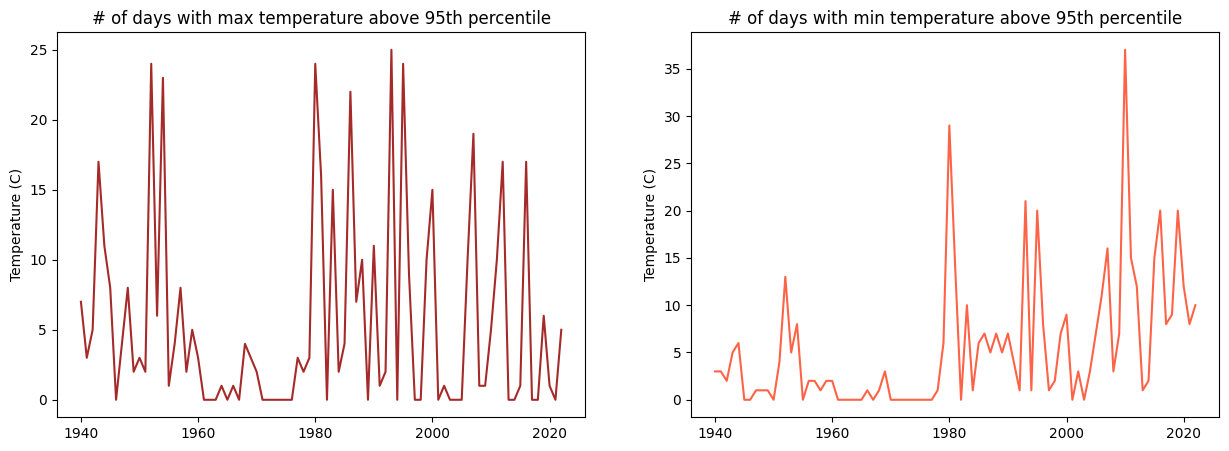

In [31]:
## make a time series plot of the change in TMAX and TMIN days above the 95th percentile:

fig, axes = plt.subplots(1, 2, figsize = (15, 5))

axes[0].plot(annual_freq["year"], annual_freq["days_above_TMAX_p95"], color = "brown")
axes[0].set(ylabel = "Temperature (C)", title = "# of days with max temperature above 95th percentile")

axes[1].plot(annual_freq["year"], annual_freq["days_above_TMIN_p95"], color = "tomato")
axes[1].set(ylabel = "Temperature (C)", title = "# of days with min temperature above 95th percentile");


In terms of daily maximum temperature, the changes are hard to discern. But it looks like there it is more common to have a higher frequency of very hot days since about 1980 compared to earlier in the time period.

In terms of daily minimum temperature, the changes are much more clear. We see that the frequency of days with very hot minimum temperatures (meaning temperatures that stay very warm overnight) has increased quite a lot. As mentioned above, the daily minimum temperature is particularly important in terms of the severity of a heat wave and how much it impacts human health and energy demand.


What are some other ways we could assess changes in the intensity or frequency of extreme hot events?


*   We could calculate changes in different thresholds, such as days above the 99th percentile, or days above 100F
*   We could the 95th percentile for the early part of the time period and for the more recent time period to compare how it is changed.
*   We could look at trends in the hottest temperature recorded each year

## Part 4: Using Extreme Value statistics to analyze very rare temperature events

In this section, we will use extreme value statistics to estimate the probability of very rare extreme events, including those that may be more rare than anything in the historical data.

Recall from class, that extreme value theory applies to "block maxima", or the maximum value in each block of time. For this case, we will consider each calendar year as a block of time. This means we need to calculate the maximum value within each year. For this analysis, we will look at TMAX.

In [32]:
## calculate annual maximum TMAX value

annual_max = pd.DataFrame(columns = ["year", "TMAX_max"], index = range(83))

for i, yr in enumerate(range(1940, 2023)):
  data_yr = summer_data[str(yr):str(yr)] # create a subset with summer data for the current year

  annual_max.loc[i, "year"] = yr
  annual_max.loc[i, "TMAX_max"] = data_yr["TMAX_degC"].max()

annual_max["TMAX_max"] = annual_max["TMAX_max"].astype("float")

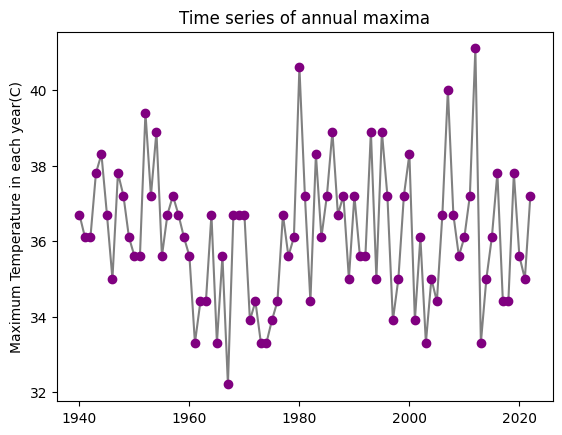

In [33]:
## plot annual maximum time series to see

fig, ax = plt.subplots()

ax.plot(annual_max["year"], annual_max["TMAX_max"], color = "gray")
ax.scatter(annual_max["year"], annual_max["TMAX_max"], color = "purple", zorder = 5)
ax.set_title("Time series of annual maxima")
ax.set_ylabel("Maximum Temperature in each year(C)");

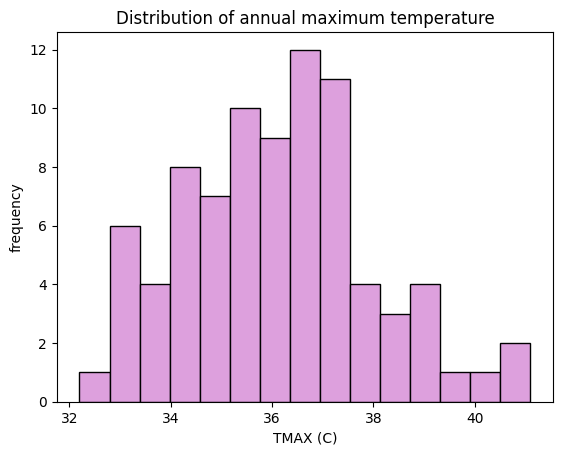

In [34]:
## plot histogram of annual maxima

fig, ax = plt.subplots()

ax.hist(annual_max["TMAX_max"], bins = 15, color = "plum", edgecolor = "black");
ax.set(title = "Distribution of annual maximum temperature", xlabel = "TMAX (C)", ylabel = "frequency");

The Fisher–Tippett–Gnedenko theorem tells us that the distribution of block maxima can be described by the Generalized Extreme Value (GEV) distribution.

The GEV distribution is described by three parameters: the location ($\mu$), the scale ($\sigma$), and the shape ($\xi$).

<img src="https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/main/lectures/img/GEV.png" width="500">

Just like we can calculate mean and standard deviation for a sample dataset, we can figure out the location, scale, and shape parameters that best match our data.

We will use the [genextreme()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html#scipy.stats.genextreme) function from the scipy package to calculate the GEV parameters for our data.  

In [37]:
## import genextreme() function

from scipy.stats import genextreme


In [38]:
## fit our data

genextreme.fit(annual_max["TMAX_max"])


(0.18943820801616493, 35.4595667483556, 1.6768574695573095)

The values correspond to the shape, the location, and the scale parameters, respectively. Let's save them as variables so we can use them later:

In [39]:
shape, location, scale = genextreme.fit(annual_max["TMAX_max"])

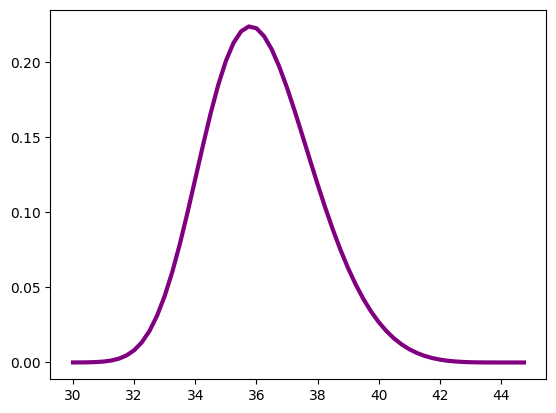

In [40]:
## make a graph of a GEV distribution with these parameters

fig, ax = plt.subplots()

x = np.arange(30,45, 0.25) # plot the data over the temperature range from 30 to 45, with 0.25 spacing in between points

ax.plot(x, genextreme.pdf(x, shape, loc=location, scale=scale), color = "purple", linewidth = 3)
ax.set(ylabel = "density", xlabel = "Temperature (C)", title = "Distribution of annual maximum temperature");

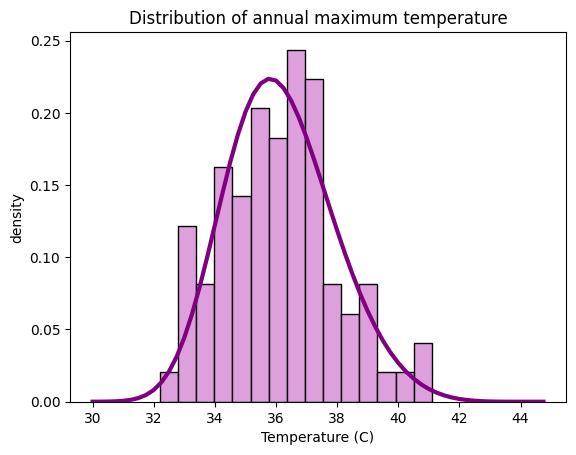

In [42]:
## plot the histogram of our data and the GEV distribution together

fig, ax = plt.subplots()

# x is already defined above

ax.plot(x, genextreme.pdf(x, shape, loc=location, scale=scale), color = "purple", linewidth = 3)
ax.set(ylabel = "density", xlabel = "Temperature (C)", title = "Distribution of annual maximum temperature");
ax.hist(annual_max["TMAX_max"], bins = 15, color = "plum", edgecolor = "black", density = True); # add density=True so y-scales line up

This looks like a decent fit for our data!

Now that we have calculated the parameters of the GEV distribution, we can calculate the magnitude of events with specific return periods (or in other words, an event with a specific probability, such as 1%). We do this using the function [genextreme.ifs()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html)

In [45]:
## what is the magnitude of a 10-year event?
# the first argument to genextreme.isf() is the probability of the event we want to know

genextreme.isf(0.1, shape, location, scale)

38.53185636279152

In [47]:
## what about a 20-year event? a 100-year event? a 500-year event?

print("The 20-year event is", round(genextreme.isf(0.05, shape, location, scale), 2), "C")
print("The 100-year event is", round(genextreme.isf(0.01, shape, location, scale), 2), "C")
print("The 500-year event is", round(genextreme.isf(0.002, shape, location, scale), 2), "C")

The 20-year event is 39.27 C
The 100-year event is 40.61 C
The 500-year event is 41.58 C


Let's make a figure showing how the event magnitude changes for different return periods:

In [48]:
## define return periods

return_periods = np.array([1.01, 1.02, 1.05, 1.1, 1.5, 2, 5, 10, 20, 30, 40, 50, 100, 200, 500, 1000])

In [49]:
## calculate magnitude for each return period
mag = genextreme.isf(1/return_periods, shape, location, scale) # the probability is 1/return period

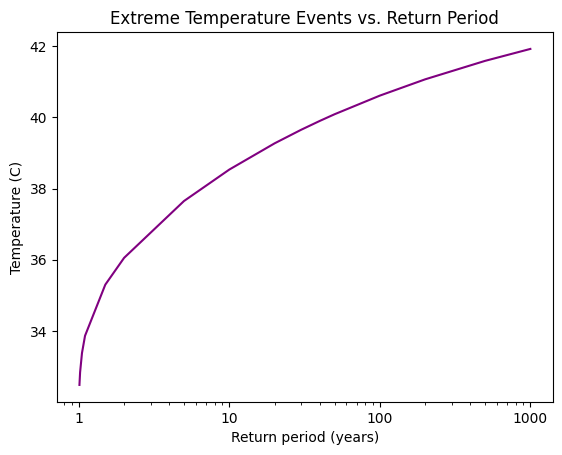

In [54]:
## make a figure showing return periods

fig, ax = plt.subplots()

ax.plot(return_periods, mag, color = "purple")

ax.set(title = "Extreme Temperature Events vs. Return Period", xlabel = "Return period (years)", ylabel = "Temperature (C)")

# format the x-axis as log scale to make it easier to see :
ax.set_xscale("log")
import matplotlib.ticker as mticker
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='x')


Let's add our data points to the plot to see how closely they match the curve. To do this, we need to calculate the *empirical* return level of each data point. The empirical return level refers to how frequently different values in our data were exceeded within the period of record.

For example, if we have 84 years of data, the most extreme event in our data has an empirical return period of 84 years because it only occurred once in 84 years. The second most extreme event has an empirical return level of 42 years because it was exceeded twice in 84 years.


In [52]:
## The function below will calculate empirical return periods for a timeseries of annual maxima

from scipy import stats

def calc_empirical_return_level(data):
    """
    Compute empirical return level
    """
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df["sorted_value"] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df["ranked_value"] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df["exceedance"] = df["ranked_value"] / (n + 1)
    # find return period
    df["return_period"] = 1 / df["exceedance"]

    df = df[::-1]

    return df

In [53]:
## calculate empirical return levels for our data

empirical_rp = calc_empirical_return_level(annual_max["TMAX_max"])

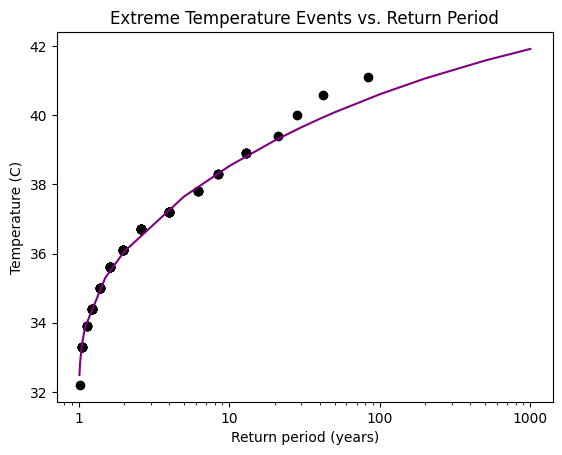

In [57]:
## make a figure showing return periods

fig, ax = plt.subplots()

ax.plot(return_periods, mag, color = "purple")
ax.scatter(empirical_rp.return_period, empirical_rp.sorted_value, color = "black") ## empirical return periods
ax.set(title = "Extreme Temperature Events vs. Return Period", xlabel = "Return period (years)", ylabel = "Temperature (C)")

# format the x-axis as log scale to make it easier to see :
ax.set_xscale("log")
import matplotlib.ticker as mticker
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='x')

We can see that our data fits the curve pretty well, although the points seem to deviate from the curve at higher return period levels. It looks like our curve might underestimate these values slightly. There are a couple reasons this could be the case:

*   We don't have that many data points, so there is some uncertainty in our estimated distribution parameters. With more data, we would likely get a better fit that would allow us to estimate rare return periods more likely
*   There were a couple assumptions we had to make for extreme value theory. These are:
   - each data point is independent
   - the data points are identically distributed (meaning they are caused by the same types of weather)
   - the data is stationary (not changing over time)

If these assumptions are not correct, the GEV distribution may not work well for our data. In this case, we know that the data is not truly stationary - climate change has been happening over time. This fact, or other violations of these assumptions, could lead to an imprecise estimate. In fact, engineers often use a different distribution - called the Log Pearson Type-III distribution, to model rare flood events, because this distribution tends to fit flood data better than the GEV distribution. It's not entirely understood why this is the case, but possibly because floods are less likely to satisfy the "identically distributed" assumption.


We have discussed on many occasions about how extreme events are changing. This means that a 100-year event now might become a 50-year event in the future! How might we address this if we are trying to analyze extreme event risk within a particular engineering application?  

*   If we know that an extreme event (such as a rain storm) will increase by a certain percentage, we can multiply our 100-year event by that percentage
*   We could design for a more rare event (such as the 200-year or 500-year event), knowing that that event may become more likely over time
*   We can run computer simulations to generate data on extreme events under future climate change. We can then calculate extreme event return periods based on this simulated data.

You will explore these three methods in HW 4. Additionally,
*   We could implement a non-stationary version of Extreme Value Analysis. This is relatively complicated so we won't discuss it in class, but NOAA is working on developing standards to use these methods in engineering practice ([here's an example report](https://hdsc.nws.noaa.gov/pfds/files25/NA14_Assessment_report_202201v1.pdf)). My guess is these methods will become readily used during your careers!
